# Исследование поведения пользователей мобильного приложения по продаже продуктов питания

## Описание проекта и постановка целей

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.

**Основные цели исследования:**

1. Исследовать воронку продаж, чтобы узнать, как пользователи доходят до покупки, а также определить, сколько застревает на предыдущих шагах и где именно.
2. Исследовать результаты А/А/В-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Требуется выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы сможем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также поможет понять, сколько времени и данных потребуется для дальнейших тестов.

Путь к файлу с логами: /datasets/logs_exp.csv

**Ход исследования:**

1. Предобработка данных
2. Изучение и проверка данных
3. Исследование воронки событий
4. Исследование результатов эксперимента

## Предобработка данных

Сперва загрузим все необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
import math as mth
from scipy import stats as st

### Предварительный осмотр

Теперь сохраним предоставленную таблицу в переменную и изучим ее:

In [2]:
df = df = pd.read_csv('logs_exp.csv', sep='\t')

df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Согласно документации:

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Посмотрим присутствие неявных дубликатов в столбце EventName:

In [4]:
df['EventName'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

**Вывод:**

- На первый взгляд, пропусков нет. 
- Названия столбцов стоит исправить на более удобные.
- Неявных дубликатов нет.

### Обработка данных

Можно приступить к исправлениями. Поправим названия столбцов:

In [5]:
df.columns=['event_name', 'user_id', 'timestamp', 'group_name']
df.columns

Index(['event_name', 'user_id', 'timestamp', 'group_name'], dtype='object')

Добавим столбец date_time с датой и временем:

In [6]:
df['date_time'] = pd.to_datetime(df['timestamp'], unit='s')

Теперь добавим столбец с датой:

In [7]:
df['date'] = df['date_time'].dt.date

df.head()

,event_name,user_id,timestamp,group_name,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Также для удобства поменяем строки в столбцах event_name и group_id, чтобы они были удобнее для чтения и понимания.

Проверим, какие строки есть в event_name:

In [8]:
df['event_name'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

С помощью функции заменим названия строк в столбце на новые:

In [9]:
def change_event_name(name):
    if name=='MainScreenAppear':
        return 'Main_Screen_Appear'
    elif name=='OffersScreenAppear':
        return 'Offers_Screen_Appear'
    elif name=='CartScreenAppear':
        return 'Cart_Screen_Appear'
    elif name=='PaymentScreenSuccessful':
        return 'Payment_Screen_Successful'
    else:
        return 'Tutorial'

Применим:

In [10]:
df['event_name'] = df['event_name'].apply(change_event_name)

df['event_name'].value_counts()

Main_Screen_Appear           119205
Offers_Screen_Appear          46825
Cart_Screen_Appear            42731
Payment_Screen_Successful     34313
Tutorial                       1052
Name: event_name, dtype: int64

С помощью похожей функции изменим строки в столбце group_name.

Проверим значения в столбце:

In [11]:
df['group_name'].value_counts()

248    85747
246    80304
247    78075
Name: group_name, dtype: int64

Напишем функцию:

In [12]:
def change_group_name(group):
    if group==246:
        return 'A1'
    elif group==247:
        return 'A2'
    elif group==248:
        return 'B'
    else:
        return 'Unknown_Group'

Применим ее и проверим итог:

In [13]:
df['group_name'] = df['group_name'].apply(change_group_name)

df['group_name'].value_counts()

B     85747
A1    80304
A2    78075
Name: group_name, dtype: int64

Проверим типы данных в получившейся таблице:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   timestamp   244126 non-null  int64         
 3   group_name  244126 non-null  object        
 4   date_time   244126 non-null  datetime64[ns]
 5   date        244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


В столбце date нужно поменять тип данных на datetime64:

In [15]:
df['date'] = df['date'].astype('datetime64')

Теперь проверим таблицу на дубликаты:

In [16]:
df.duplicated().sum()

413

Удалим их:

In [17]:
df = df.drop_duplicates().reset_index(drop=True)

Выведем таблицу после всех исправлений:

In [18]:
df.head(10)

,event_name,user_id,timestamp,group_name,date_time,date
0,Main_Screen_Appear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,Main_Screen_Appear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,Payment_Screen_Successful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,Cart_Screen_Appear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,Payment_Screen_Successful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
5,Cart_Screen_Appear,6217807653094995999,1564055323,B,2019-07-25 11:48:43,2019-07-25
6,Offers_Screen_Appear,8351860793733343758,1564066242,A1,2019-07-25 14:50:42,2019-07-25
7,Main_Screen_Appear,5682100281902512875,1564085677,A1,2019-07-25 20:14:37,2019-07-25
8,Main_Screen_Appear,1850981295691852772,1564086702,A2,2019-07-25 20:31:42,2019-07-25
9,Main_Screen_Appear,5407636962369102641,1564112112,A1,2019-07-26 03:35:12,2019-07-26


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   group_name  243713 non-null  object        
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


Теперь осталось только проверить наличие пересечений пользователей между группами. 

Для этого мы можем посчитать количество уникальных пользователей во всем датафрейме, и затем в каждой группе отдельно. Если сумма значений трех групп окажется равной общему числу пользователей, то это будет означать, что ни один пользователь не находится в двух и более группах сразу.

In [20]:
sum = 0
for i in df['group_name'].unique():
    user_group = df[df['group_name']==i]['user_id'].nunique()
    sum = sum + user_group
    print('В группе', i,'уникальных пользователей:', user_group)

print('При сложении трех групп число уникальных пользователей равно:', sum)
print('Всего уникальных пользоваталей в датафрейме:', df['user_id'].nunique())

В группе A1 уникальных пользователей: 2489
В группе B уникальных пользователей: 2542
В группе A2 уникальных пользователей: 2520
При сложении трех групп число уникальных пользователей равно: 7551
Всего уникальных пользоваталей в датафрейме: 7551


Как мы видим, цифры совпали. Мы можем считать, что пересечений по пользователям между группами в таблице нет.

**Вывод:**

В процессе обработки мы внесли следующие исправления:
- Названия столбцов заменили на более удобные.
- Добавили столбцы с датой и датой/временем.
- Привели типы данных в столбцах к соответствующим.
- Заменили строки в столбцах event_name и group_name на более наглядные.
- Удалили 413 дубликатов.

Мы также проверили таблицу на присутствие пересечений пользователей между группами, и постановили их отсутствие. 

Таблица готова для дальнейшей работы.

## Изучение и проверка данных

### Подсчет кол-ва событий

Ответим на вопрос: "Сколько всего событий в логе?"

In [21]:
event_count = df['event_name'].count()
print('Событий в логе:', event_count)

Событий в логе: 243713


**Вывод:**

Всего событий в логе: 243713

### Подсчет кол-ва пользователей

Ответим на вопрос: "Сколько всего пользователей в логе?"

In [22]:
user_count = df['user_id'].nunique()

print('Уникальных пользователей в логе:', user_count)
print(' ')
print('Уникальных пользователей в логе по группам:')

df.groupby('group_name')['user_id'].nunique()

Уникальных пользователей в логе: 7551
 
Уникальных пользователей в логе по группам:


group_name
A1    2489
A2    2520
B     2542
Name: user_id, dtype: int64

**Вывод:**

- Уникальных пользователей в логе: 7551
- Уникальных пользователей в группе А1: 2489
- Уникальных пользователей в группе А2: 2520
- Уникальных пользователей в группе B: 2542

### Подсчет среднего кол-ва событий на пользователя

Ответим на вопрос: "Сколько в среднем событий приходится на пользователя?"

Для начала проверим распределение количества событий на одного пользователя:

In [23]:
event_per_user = df.groupby('user_id')['event_name'].count()
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

Мы видим, что в среднем на одного пользователя приходится по 32 события.

Составим гистограмму, чтобы определить наличие выбросов:

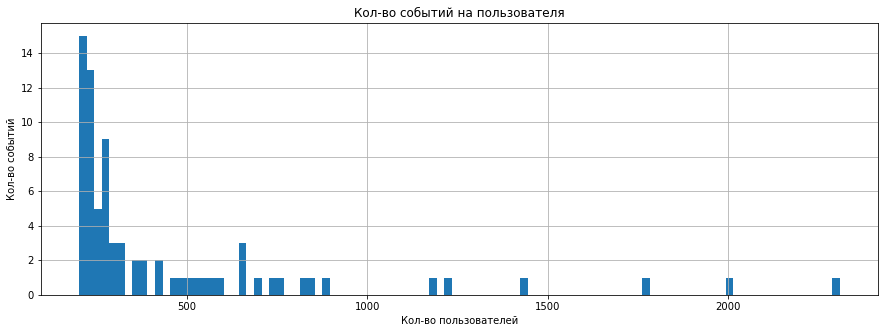

In [24]:
plt.figure(figsize=(15,5))
plt.hist(event_per_user, bins=100, range=(200,2310)) 
plt.xlabel('Кол-во пользователей')
plt.grid()
plt.ylabel('Кол-во событий')
plt.title('Кол-во событий на пользователя')
plt.show()

Мы наблюдаем довольно большое количество выбросов. Это следует учитывать, и для более точного определения среднего числа пользователей использовать медиану, тоесть по 20 событий на пользователя.

**Вывод:**
- По среднему значению на одного пользователя приходится по 32 события.
- По медианному значению на одного пользователя приходится по 20 событий.
- Из-за большого числа выбросов, лучше использовать медианное значение.

### Распределение данных во времени

Требуется определить, за какой временной период мы располагаем данными. 

Для этого найдем максимальную и минимальную дату, а потом построим гистограмму по дате и времени.

In [25]:
print('Период за который рассматриваем данные:', df['date_time'].min(),'-',df['date_time'].max())

Период за который рассматриваем данные: 2019-07-25 04:43:36 - 2019-08-07 21:15:17


Временной период чуть меньше двух недель. 

Составим по гистограмму по столбцу даты и времени:

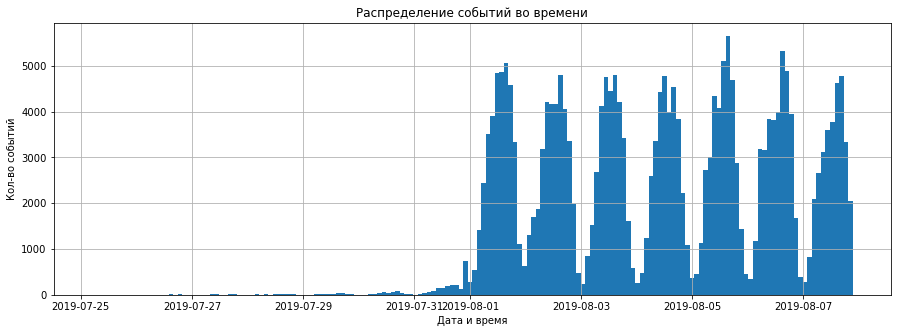

In [26]:
plt.figure(figsize=(15,5))
plt.hist(df['date_time'], bins=24*7) 
plt.xlabel('Дата и время')
plt.grid()
plt.ylabel('Кол-во событий')
plt.title('Распределение событий во времени')
plt.show()

Судя по графику, мы видим, что у нас есть данные только по первой неделе августа. В данном случае корректнее всего будет отсечь все данные за июль, чтобы они не мешались позже.

In [27]:
df_clean = df.loc[df['date'] > '2019-07-31'].reset_index(drop=True)

Осмотрим новый "чистый" датафрейм:

In [28]:
df_clean.sort_values(by='date_time').head(10)

,event_name,user_id,timestamp,group_name,date_time,date
0,Tutorial,3737462046622621720,1564618048,A1,2019-08-01 00:07:28,2019-08-01
1,Main_Screen_Appear,3737462046622621720,1564618080,A1,2019-08-01 00:08:00,2019-08-01
2,Main_Screen_Appear,3737462046622621720,1564618135,A1,2019-08-01 00:08:55,2019-08-01
3,Offers_Screen_Appear,3737462046622621720,1564618138,A1,2019-08-01 00:08:58,2019-08-01
4,Main_Screen_Appear,1433840883824088890,1564618139,A2,2019-08-01 00:08:59,2019-08-01
5,Main_Screen_Appear,4899590676214355127,1564618215,A2,2019-08-01 00:10:15,2019-08-01
6,Offers_Screen_Appear,3737462046622621720,1564618226,A1,2019-08-01 00:10:26,2019-08-01
7,Main_Screen_Appear,3737462046622621720,1564618247,A1,2019-08-01 00:10:47,2019-08-01
8,Main_Screen_Appear,3737462046622621720,1564618270,A1,2019-08-01 00:11:10,2019-08-01
9,Main_Screen_Appear,3737462046622621720,1564618280,A1,2019-08-01 00:11:20,2019-08-01


**Выводы:**

- Мы располагаем данными за период с 2019-07-25 по 2019-08-07 числа включительно.
- По гистограмме распределения данных во времени, мы постановили, что основная масса данных приходится на период с 2019-08-01 по 2019-08-07 числа включительно.
- Мы отсекли данные за июль, чтобы они не искажали результаты дальнейшего анализа.

### Кол-во отрезанных данных

Требуется посчитать, сколько данных мы потеряли в результате очистки.

Посчитаем потери в кол-ве пользователей:

In [29]:
new_user_count = df_clean['user_id'].nunique()

print('Было пользователей:', user_count)
print('Стало пользователей:', new_user_count)
print('Кол-во потерянных пользователей:', user_count - new_user_count)
print('Кол-во потерянных пользователей в процентах:', round((user_count - new_user_count)/user_count*100,2),'%')

Было пользователей: 7551
Стало пользователей: 7534
Кол-во потерянных пользователей: 17
Кол-во потерянных пользователей в процентах: 0.23 %


Теперь посчитаем потери в кол-ве событий:

In [30]:
new_event_count = df_clean['event_name'].count()

print('Было событий:', event_count)
print('Стало событий:', new_event_count)
print('Кол-во потерянных событий:', event_count - new_event_count)
print('Кол-во потерянных событий в процентах:', round((event_count - new_event_count)/event_count*100,2),'%')

Было событий: 243713
Стало событий: 240887
Кол-во потерянных событий: 2826
Кол-во потерянных событий в процентах: 1.16 %


**Выводы:**

- В результате очистки мы потеряли 17 пользователей, что составляет 0.23% от всех.
- В результате очистки мы потеряли 2826 событий, что составляет 1.16% от всех.
- Потери находятся в пределах допустимых значений.

### Проверка пользователей в группах

Осталось проверить, что у нас есть пользователи из всех трех экспериментальных групп.

In [31]:
df_clean.groupby('group_name')['user_id'].nunique()

group_name
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Как мы видим, в каждой группе примерно по 2,5 тысячи пользователей.

**Выводы:**
- В группе А1 осталось 2484 пользователя.
- В группе А2 осталось 2513 пользователей.
- В группе В осталось 2537 пользователей.

## Исследование воронки событий

### Исследование событий

Посмотрим, какие события есть в логах, и как часто они встречаются, а также отсортируем их по частоте с помощью value_counts():

In [32]:
df_clean['event_name'].value_counts()

Main_Screen_Appear           117328
Offers_Screen_Appear          46333
Cart_Screen_Appear            42303
Payment_Screen_Successful     33918
Tutorial                       1005
Name: event_name, dtype: int64

Названия событий можно интерпретировать так:
- Main_Screen_Appear - показ основного экрана
- Offers_Screen_Appear - показ экрана предложений
- Cart_Screen_Appear - показ экрана корзины
- Payment_Screen_Successful - показ экрана с подтверждением оплаты
- Tutorial - показ обучения

**Вывод:**
- Самым частым событием является показ основного экрана. 
- Дальше по порядку убывания: показ экрана предложений, показ экрана корзины, показ экрана с подтверждением оплаты.
- Самым немногочисленным событием является показ обучения.

### Кол-во пользователей на событие

Посчитаем, сколько пользователей совершали каждое их этих событий, и отсортируем события по числу пользователей.

In [33]:
users_per_event = df.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
users_per_event.columns = ['user_count']
users_per_event = users_per_event.reset_index()
users_per_event

,event_name,user_count
0,Main_Screen_Appear,7439
1,Offers_Screen_Appear,4613
2,Cart_Screen_Appear,3749
3,Payment_Screen_Successful,3547
4,Tutorial,847


Добавим в получившуюся таблицу столбец с долями пользователей, которые хоть раз совершали событие:

In [34]:
users_per_event['user_percentage'] = (users_per_event['user_count'] / new_user_count * 100).round(1)
users_per_event

,event_name,user_count,user_percentage
0,Main_Screen_Appear,7439,98.7
1,Offers_Screen_Appear,4613,61.2
2,Cart_Screen_Appear,3749,49.8
3,Payment_Screen_Successful,3547,47.1
4,Tutorial,847,11.2


**Вывод:**

По таблице мы видим, что:
- Событие "показ основного экрана" совершили 7439 пользователей, что составляет 98.7% от всех пользователей.
- Событие "показ экрана предложений" совершили 4613 пользователей, что составляет 61.2% от всех.
- Событие "показ экрана корзины" совершили 3749 пользователей, что составляет 49.8% от всех.
- Событие "показ экрана подтверждения оплаты" совершили 3547 пользователей, что составляет 47.7% от всех.
- Событие "показ обучения" совершили 847 пользователей, что составило лишь 11.2% от всех.

### Порядок событий

Предположительно, воронка продаж выглядит следующим образом:
1. Пользователь видит основной экран сайта
2. Пользователь переходит на экран предлагаемых товаров
3. Пользователь добавляет товары в корзину и переходит на ее экран
4. Пользователь оплачивает заказ и переходит на экран подтверждения оплаты

Дополнительно у нас есть событие - обучение. Судя по маленькому проценту пользователей (11.2 %), которые заходят на ее страницу, она вряд ли является частью воронки продаж. Скорее всего это просто обучение пользователя, как правильно использовать сайт, и потому не является обязательным.

**Вывод:**

Событие "показ обучения" можно не учитывать при расчете воронки продаж.

### Доля пользователей по шагам воронки



Как мы постановили ранее, событие "показ обучения" не является частью воронки. Потому можем убрать его из таблицы для дальнейшего анализа:

In [35]:
users_per_event = users_per_event.drop([4], 0)
users_per_event

C:\Users\Taras\AppData\Local\Temp/ipykernel_20096/1626069150.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  users_per_event = users_per_event.drop([4], 0)


,event_name,user_count,user_percentage
0,Main_Screen_Appear,7439,98.7
1,Offers_Screen_Appear,4613,61.2
2,Cart_Screen_Appear,3749,49.8
3,Payment_Screen_Successful,3547,47.1


Теперь посчитаем по воронке событий, какая доля пользователей от числа пользователей на предыдущем шаге, переходит на следующий шаг воронки.

Для этого создадим столбец с конверсией:

In [36]:
previus_users = users_per_event.loc[0,'user_count']

for i in users_per_event.index:
    users_per_event.loc[i, 'conversion'] = (users_per_event.loc[i,'user_count'] / previus_users * 100).round(1)
    previus_users = users_per_event.loc[i,'user_count']
    
users_per_event

,event_name,user_count,user_percentage,conversion
0,Main_Screen_Appear,7439,98.7,100.0
1,Offers_Screen_Appear,4613,61.2,62.0
2,Cart_Screen_Appear,3749,49.8,81.3
3,Payment_Screen_Successful,3547,47.1,94.6


**Вывод:**

По таблице мы видим, что:
- С 1-го шага воронки на 2-й перешло 62% от пользователей предыдущего шага.
- Со 2-го шага на 3-й перешло 81.3% от пользователей предыдущего шага.
- С 3-го на 4-й перешло 94.6% от пользователей предыдущего шага.

### Потери пользователей по шагам

Требуется посчитать, на каком шаге мы теряем больше всего пользователей.

Для этого добавим новый столбец в таблицу, где будут указаны потери относительно предыдущего шага.

In [37]:
for i in users_per_event.index:
    users_per_event.loc[i, 'losses'] = 100 - users_per_event.loc[i, 'conversion']
    
users_per_event

,event_name,user_count,user_percentage,conversion,losses
0,Main_Screen_Appear,7439,98.7,100.0,0.0
1,Offers_Screen_Appear,4613,61.2,62.0,38.0
2,Cart_Screen_Appear,3749,49.8,81.3,18.7
3,Payment_Screen_Successful,3547,47.1,94.6,5.4


**Вывод:**

Во время перехода к экрану с предложениями мы теряем наибольший процент пользователей - 38 %. Возможно, существует какая то проблема на первом шаге "показ основного экрана". Об этом следует сообщить тестировщикам, чтобы выяснить причину.

### Доля пользователей, дошедших от первого события до последнего

Требуется посчитать, какая доля пользователей доходит от первого события до оплаты. Для этого добавим в таблицу еще один столбец, рассчитав его похожим образом, как в пункте 4.4, но с одним отличием:

In [38]:
starting_users = users_per_event.loc[0,'user_count']

for i in users_per_event.index:
    users_per_event.loc[i, 'users_left'] = (users_per_event.loc[i,'user_count'] / starting_users * 100).round(1)
    
users_per_event

,event_name,user_count,user_percentage,conversion,losses,users_left
0,Main_Screen_Appear,7439,98.7,100.0,0.0,100.0
1,Offers_Screen_Appear,4613,61.2,62.0,38.0,62.0
2,Cart_Screen_Appear,3749,49.8,81.3,18.7,50.4
3,Payment_Screen_Successful,3547,47.1,94.6,5.4,47.7


**Вывод:**

От первого до последнего шага доходит только 47.7 % пользователей. Это почти половина всех пользователей, что можно считать хорошим результатом, особенно учитывая 38 % пользователей, которых мы теряем на втором шаге.

## Исследование результатов эксперимента

### Кол-во пользователей в каждой экспериментальной группе

Требуется узнать, сколько пользователей присутствует в каждой экспериментальной группе. Похожий код мы делали в пункте 3.6.

Повторим его для наглядности, но на этот раз сохраним полученную таблицу в переменную. Этот датасет понадобится нам для тестов позже.

In [39]:
users_per_group = df_clean.groupby('group_name')['user_id'].nunique()
users_per_group

group_name
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

**Выводы:**
- В группе A1: 2484 пользователей.
- В группе A2: 2513 пользователей.
- В группе B: 2537 пользователей.
- Пользователи распределены по группам примерно равномерно.

### Кол-во пользователей по событим и группам

Составим таблицу, в которой будет указано число пользователей для каждого шага воронки, разделенные по группам.

Не забудем исключить событие Tutorial.

In [40]:
group_count = df_clean[df_clean['event_name']!='Tutorial'].pivot_table(
    index='event_name', 
    columns='group_name', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

group_count = group_count.reset_index()
group_count

group_name,event_name,A1,A2,B
0,Main_Screen_Appear,2450,2476,2493
1,Offers_Screen_Appear,1542,1520,1531
2,Cart_Screen_Appear,1266,1238,1230
3,Payment_Screen_Successful,1200,1158,1181


От нас требуется посчитать число пользователей и долю пользователей по всем группам для самого популярного события.

Чтобы определить, какое событие самое популярное, добавим к таблице сверху столбец с общим числом пользователей по событиям, а также столбец с долями для этих пользователей.

In [41]:
group_count['total'] = group_count['A1'] + group_count['A2'] + group_count['B']
group_count['A1_%'] = (group_count['A1'] / users_per_group['A1'] * 100).round(1)
group_count['A2_%'] = (group_count['A2'] / users_per_group['A2'] * 100).round(1)
group_count['B_%'] = (group_count['B'] / users_per_group['B'] * 100).round(1)
group_count['total_%'] = (group_count['total'] / users_per_group.sum() * 100).round(1)
group_count

group_name,event_name,A1,A2,B,total,A1_%,A2_%,B_%,total_%
0,Main_Screen_Appear,2450,2476,2493,7419,98.6,98.5,98.3,98.5
1,Offers_Screen_Appear,1542,1520,1531,4593,62.1,60.5,60.3,61.0
2,Cart_Screen_Appear,1266,1238,1230,3734,51.0,49.3,48.5,49.6
3,Payment_Screen_Successful,1200,1158,1181,3539,48.3,46.1,46.6,47.0


**Выводы:**
- Самым популярным событием является Main_Screen_Appear (появление основного экрана), набравшее 7419 пользователей. Что достаточно очевидно, учитывая, что оно стоит первым в воронке. Если распределять по группам, то выходит:
    - Группа А1: 2450 пользователей.
    - Группа А2: 2476 пользователей.
    - Группа В: 2493 пользователя.
- Доля пользователей, совершивших это событие составляет 98.5%. Если распределять по группам, то выходит:
    - Группа А1: 98.6%.
    - Группа А2: 98.5%.
    - Группа В: 98.3%

### Статистическая значимость различий между двумя контрольными группами

Теперь мы можем сделать первую серию тестов.

Чтобы оценить различия для двух групп, мы будем сравнивать их по долям из каждого событию по отдельности. (Тест на величину Z.) Если все события для двух групп окажутся одинаковыми, то различия в группах можно считать незначительными.

Поскольку нам предстоит повторять один и тот же тест множество раз, лучше всего будет написать для их проверки общую функцию.

Нулевая и альтернативная гипотеза будут одинаковые для всех тестов.

В качестве нулевой гипотезы возьмем: "Разница в долях пользователей, совершивших событие, статистически незначима."

Альтернативная гипотеза тогда будет: "Разница в долях пользователей, совершивших событие, статистически значима."

Поскольку обе группы для А/А-теста должны быть одинаковыми, то уровень статистической значимости для их сравнения должен быть выше - 1%. Потому в качестве порогового значения alpha возьмем 0.01.

Теперь напишем саму функцию. На вход она будет принимать две группы, которые мы сравниваем, и значение alpha. Также добавим туда счетчик, чтобы знали, сколько тестов мы выполнили в сумме:

In [42]:
def z_test(group_1, group_2, alpha, count):
    counter = count
    for i in group_count.index:
        p1 = group_count[group_1][i] / users_per_group[group_1]
        p2 = group_count[group_2][i] / users_per_group[group_2]
        p_combined = ((group_count[group_1][i] + group_count[group_2][i]) / 
                      (users_per_group[group_1] + users_per_group[group_2]))
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_per_group[group_1] + 1/users_per_group[group_2])) 
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('Событие:', group_count['event_name'][i])
        print('P-значение:', round(p_value, 3))
        if (p_value < alpha):
            print('Отвергаем нулевую гипотезу.')
        else:
            print('Нулевую гипотезу отвергнуть не удалось.')
        counter += 1
        print('Всего тестов выполненно:', counter)
        print('')

Теперь, мы можем проверить разницу между выборками А1 и А2.

Применим функцию. Нам также нужно знать общее число тестов, которое мы совершим, потому добавим счетчик:

In [43]:
z_test('A1', 'A2', 0.01, 0)

Событие: Main_Screen_Appear
P-значение: 0.757
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 1

Событие: Offers_Screen_Appear
P-значение: 0.248
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 2

Событие: Cart_Screen_Appear
P-значение: 0.229
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 3

Событие: Payment_Screen_Successful
P-значение: 0.115
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 4



Ведем счет: 4 теста выполненно.

**Вывод:**
- Нулевую гипотезу не удалось отвергнуть по всем событиям воронки.
- Можно сделать вывод, что статистически значимых различий между группами А1 и А2 нет.

### Статистическая значимость различий между контрольными и экспериментальной группами

От нас также требуется сравнить группу с измененными шрифтами (группу В) с каждой из контрольных групп по отдельности, а потом с объединенной контрольной группой. 

Для этих тестов уровень статистической значимости может быть не настолько строгим. Однако, при уровне значимости в 10% каждый десятый эксперимент может дать ложный результат. 

Мы же планируем сделать 12 различных тестов. Потому уровень значимости решено было поднять до 5%. 

Для этого пороговое значение alpha далее будет равно 0.05.

Укажем в счетчике цифру 4.

**Эксперимент А1/В**

In [44]:
z_test('A1', 'B', 0.05, 4)

Событие: Main_Screen_Appear
P-значение: 0.295
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 5

Событие: Offers_Screen_Appear
P-значение: 0.208
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 6

Событие: Cart_Screen_Appear
P-значение: 0.078
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 7

Событие: Payment_Screen_Successful
P-значение: 0.212
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 8



**Эксперимент A2/B**

В счетчике укажем цифру 8.

In [45]:
z_test('A2', 'B', 0.05, 8)

Событие: Main_Screen_Appear
P-значение: 0.459
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 9

Событие: Offers_Screen_Appear
P-значение: 0.92
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 10

Событие: Cart_Screen_Appear
P-значение: 0.579
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 11

Событие: Payment_Screen_Successful
P-значение: 0.737
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 12



**Эксперимент A1+A2/B**

Прежде чем продолжить, сначала добавим в таблицы users_per_group и group_count столбцы и строки со значением объединенных таблиц A1 и A2:

In [46]:
users_per_group['A1+A2'] = users_per_group['A1'] + users_per_group['A2']
users_per_group

group_name
A1       2484
A2       2513
B        2537
A1+A2    4997
Name: user_id, dtype: int64

In [47]:
group_count['A1+A2'] = group_count['A1'] + group_count['A2']
group_count

group_name,event_name,A1,A2,B,total,A1_%,A2_%,B_%,total_%,A1+A2
0,Main_Screen_Appear,2450,2476,2493,7419,98.6,98.5,98.3,98.5,4926
1,Offers_Screen_Appear,1542,1520,1531,4593,62.1,60.5,60.3,61.0,3062
2,Cart_Screen_Appear,1266,1238,1230,3734,51.0,49.3,48.5,49.6,2504
3,Payment_Screen_Successful,1200,1158,1181,3539,48.3,46.1,46.6,47.0,2358


Теперь мы можем использовать функцию. В счетчике укажем число прошедших тестов - 12:

In [48]:
z_test('A1+A2', 'B', 0.05, 12)

Событие: Main_Screen_Appear
P-значение: 0.294
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 13

Событие: Offers_Screen_Appear
P-значение: 0.434
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 14

Событие: Cart_Screen_Appear
P-значение: 0.182
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 15

Событие: Payment_Screen_Successful
P-значение: 0.6
Нулевую гипотезу отвергнуть не удалось.
Всего тестов выполненно: 16



**Выводы:**
- В сумме мы совершили 16 проверок.
- Во всех тестах нулевую гипотезу не удалось отвергнуть.
- Это значит, что среди всех групп статистически значимой разницы обнаружить не удалось.
- Можно утверждать, что изменение шрифта на поведение пользователей никакого влияния не оказало.

## Итоги

В ходе исследования мы совершили следующие действия:
1. Мы обработали предоставленный датафрейм и внесли необходимые исправления:
    - Названия столбцов заменили на более удобные и заменили на нижний регистр.
    - Добавили столбцы с датой и датой/временем.
    - Привели типы данных в столбцах к соответствующим.
    - Заменили строки в столбцах event_name на более наглядные.
    - Замени названия экспериментальных групп с набора цифр на А1, А2 и В для простоты.
    - Удалили 413 дубликатов.
    - Мы проверили датафрейм на пересечения пользователей между группами, и определили, что пересечение отсутствует.
2. Мы изучили и проверили данные, предоставленные в датафрейме. Мы постановили следующее:
    - Всего событий в логе: 243713. Уникальных пользователей в логе: 7551. Уникальных пользователей в группе А1: 2489. Уникальных пользователей в группе А2: 2520. Уникальных пользователей в группе B: 2542
    - По среднему значению на одного пользователя приходится по 32 события. Но из-за большого числа выбросов, рациональнее использовать медианное значение: 20 событий на пользователя.
    - Мы создали график распределения данных по времени, и узнали, мы располагаем данными за период с 2019-07-25 по 2019-08-07 числа включительно. Однако, основная масса данных приходится на период с 2019-08-01 по 2019-08-07 числа включительно. Потому мы отсекли данные за июль, чтобы они не искажали результаты дальнейшего анализа.
    - В результате очистки мы потеряли 17 пользователей (0.23% от всех) и 2826 событий (1.16% от всех). Потери находятся в пределах допустимых значений.
3. Мы исследовали воронку событий, и постановили следующее:
    - Порядок воронки выглядит так: 
        1. Main_Screen_Appear, "открытие основного экрана" (117328 событий, самое популярное событие); 
        2. Offers_Screen_Appear, "открытие экрана предложений" (46333 событий);
        3. Cart_Screen_Appear, "открытие экрана корзины" (42303 событий);
        4. Payment_Screen_Successful, "открытие экрана подтверждения оплаты" (33918 событий).
    - Событие Tutorial, "открытие обучения", в воронку событий не входит.
    - На второй этап воронки попадает 61.2% пользователей, где 38% "теряются" по пути. Скорее всего где-то на основном экране находится какая-то проблема, которую следует подробнее изучить тестировщикам.
    - В итоге от первого до последнего шага воронки доходит 47.7% пользователей, что является относительно хорошим результатом, особенно если учитывать потери на втором шаге.
4. Мы провели ряд тестов, в которых оценивали статистические различия между группами А1, А2 и В. Мы постановили, следующее:
    - В группе A1: 2484 пользователей. В группе A2: 2513 пользователей. В группе B: 2537 пользователей. Пользователи распределены по группам примерно равномерно.
    - Самым популярным событием во всех группах является событие Main_Screen_Appear, "открытие основного экрана", набравшее 7419 пользователей (98.5%). Если распределять по группам, то выходит:
        - Группа А1: 2450 пользователей (98.6%)
        - Группа А2: 2476 пользователей (98.5%)
        - Группа В: 2493 пользователей (98.3%)
    - Мы также провели 16 различных тестов, чтобы оценить статистическую значимость различий между группами А1, А2 и В, попарно сравнивая группы по четырем шагам воронки событий:
        - Тест А1/А2, статистическая значимость: 1%.
        - Тест А1/В, статистическая значимость: 5%.
        - Тест А2/В, статистическая значимость: 5%.
        - Тест А1+А2/В, статистическая значимость: 5%.
    - Ни один из тестов не показал присутствие статистически значимых различий между группами.
    
Из всего вышеперечисленного можно сделать следующие финальные заключения:
- Требуется тестирование события "открытие основного экрана", чтобы выявить возможную ошибку.
- Существенной разницы между группами обнаружено не было.
- **Можно принять решение остановить тестирование, и заключить, что изменения шрифта никак не повлияло на поведение пользователей.**